In [1]:
! pip install langgraph langchain dotenv 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install langchain_huggingface


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from langgraph.graph import StateGraph, START,END
from typing import TypedDict,Optional,List,Dict,Literal,Any
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser
from pydantic import BaseModel,Field
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from langchain_core.prompts import PromptTemplate
import os

d:\Desktop\Assignment---Guppshupp\envv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
class MemoryState(TypedDict):
    messages:List[Dict[str,str]]
    all_messages:str
    preferences:List[str]
    emotional_pattrens:list[str]
    facts:list[str]
    
    

In [6]:
def extract(state:MemoryState):
    all_msg="\n".join(msg["content"] for msg in state["messages"] if msg["role"]=="user")
    
    return {"all_messages":all_msg}


In [7]:
def load_preference(state: MemoryState):
    text = state["all_messages"]

    class Pattern(BaseModel):
        preferences: List[str] = Field(default_factory=list)

    parser = PydanticOutputParser(pydantic_object=Pattern)

    # LLM
    llm = HuggingFaceEndpoint(
        repo_id="openai/gpt-oss-20b",
        temperature=0.0,
        task="text-generation"
    )
    model = ChatHuggingFace(llm=llm)

    # Prompt
    prompt = PromptTemplate(template="""Extract the user's stable preferences from the conversation below.Return ONLY valid JSON that matches this format:{format_instructions} Conversation text:{text}""",
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()})

    chain = prompt | model | parser

    try:
        result = chain.invoke({"text": text})
        return {"preferences": result.preferences}

    except Exception as e:
        print("Error parsing output:", e)

        # Get raw model output to debug
        raw_output = (prompt | model).invoke({"text": text})
        print("Raw output:", raw_output)

        return {"preferences": []}


In [8]:
def emotional_pattrens(state: MemoryState):
    text = state["all_messages"]

    # Define Pydantic model
    class EmotionPattern(BaseModel):
        emotional_pattrens: List[str] = Field(default_factory=list)

    parser = PydanticOutputParser(pydantic_object=EmotionPattern)

    # HuggingFace LLM setup
    llm = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.0,task="text-generation")
    model = ChatHuggingFace(llm=llm)

    # Prompt for LLM
    prompt = PromptTemplate(template="""Extract user emotions from the text below. Return ONLY a valid JSON object with a key "emotional_pattrens" as a list of strings.
                            Text:
        {text} {format_instructions} """,
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | model | parser

    try:
        result = chain.invoke({"text": text})
        return {"emotional_pattrens": result.emotional_pattrens}
    except Exception as e:
        print("Error parsing output:", e)
        raw_output = chain.invoke({"text": text}, return_raw=True)
        print("Raw output:", raw_output)
        return {"emotional_pattrens": []}


In [9]:
def load_facts(state: MemoryState):
    text = state["all_messages"]

    # Define Pydantic model
    class FactsPattern(BaseModel):
        facts: List[str] = Field(default_factory=list)

    parser = PydanticOutputParser(pydantic_object=FactsPattern)

    # HuggingFace LLM setup
    llm = HuggingFaceEndpoint(
        repo_id="openai/gpt-oss-20b",
        temperature=0.0,
        task="text-generation"
    )
    model = ChatHuggingFace(llm=llm)

    # Prompt for LLM
    prompt = PromptTemplate(template="""Extract objective facts from the text below.Return ONLY a valid JSON object with a key "facts" as a list of strings.
        Text: {text} {format_instructions}""",
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()})

    chain = prompt | model | parser

    try:
        result = chain.invoke({"text": text})
        return {"facts": result.facts}
    except Exception as e:
        print("Error parsing output:", e)
        raw_output = chain.invoke({"text": text}, return_raw=True)
        print("Raw output:", raw_output)
        return {"facts": []}


In [10]:
import json

In [11]:
def save_memory(state:MemoryState):
    preferences=state["preferences"]
    facts=state["facts"]
    emotional_pattrens=state["emotional_pattrens"]
    
    memory_data = {
        "preferences": preferences,
        "emotional_pattrens":emotional_pattrens,
        "facts":facts
    }
    
    with open("memory.json","w") as f:
        json.dump(memory_data,f,indent=2)
        
    return state
    

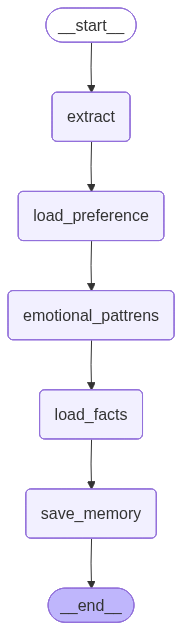

In [12]:
graph=StateGraph(MemoryState)

graph.add_node("extract",extract)
graph.add_node("load_preference",load_preference)
graph.add_node("emotional_pattrens",emotional_pattrens)
graph.add_node("load_facts",load_facts)
graph.add_node("save_memory",save_memory)

graph.add_edge(START,"extract")
graph.add_edge("extract","load_preference")
graph.add_edge("load_preference","emotional_pattrens")
graph.add_edge("emotional_pattrens","load_facts")
graph.add_edge("load_facts","save_memory")
graph.add_edge("save_memory",END)


workflow=graph.compile()
workflow
    

In [13]:
initial_state={"messages": [
    {"role": "user", "content": "I love eating Italian food and pizza."},
    {"role": "user", "content": "I usually wake up at 6 AM every day."},
    {"role": "user", "content": "I feel stressed whenever deadlines approach."},
    {"role": "user", "content": "I enjoy watching sci-fi movies in my free time."},
    {"role": "user", "content": "I am an introverted person and like quiet places."},
    {"role": "user", "content": "I like listening to classical music while working."},
    {"role": "user", "content": "I live in New York and work as a software engineer."},
    {"role": "user", "content": "I prefer working at night instead of mornings."},
    {"role": "user", "content": "I am allergic to peanuts and always avoid them."},
    {"role": "user", "content": "I feel excited when learning new programming languages."}
]}


In [14]:
output=workflow.invoke(initial_state)
print(output["preferences"])
print(output["emotional_pattrens"])
print(output["facts"])


d:\Desktop\Assignment---Guppshupp\envv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Italian food', 'pizza', 'wakes up at 6 AM', 'sci-fi movies', 'quiet places', 'classical music', 'night work', 'learning new programming languages']
['love', 'stressed', 'excited', 'enjoyment']
['I usually wake up at 6 AM every day.', 'I live in New York and work as a software engineer.', 'I am allergic to peanuts.']


In [15]:
from typing import TypedDict, List, Dict,Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class PersonalityState(TypedDict):
    messages:Annotated[List[BaseMessage],add_messages]   
    memory: Dict[str,Any]     
    tone:str                                                 
    base_response: str                    
    final_response: str                   

In [16]:
MEMORY_FILE = "memory.json"

def load_memory_file() -> Dict[str, Any]:
    """Load memory.json if exists, else return empty structured memory."""
    if not os.path.exists(MEMORY_FILE):
        return {"preferences": {},"facts": {},"emotional_patterns": {}}
    with open(MEMORY_FILE, "r") as f:
        try:
            return json.load(f)
        except Exception:
            return {"preferences": {},"facts": {},"emotional_patterns": {}}
        
    

In [17]:
def retriever_memory(state:PersonalityState):
    memory=load_memory_file()
    
    return {"memory":memory}
    

In [18]:
def generate_neutral_response(state:PersonalityState):
    
    message=state["messages"][-1].content
    
    prompt=PromptTemplate(template="""You are a helpful assistant. Given the user's message below, produce a concise helpful reply.
    Do NOT adopt any specific persona or unusual tone — neutral and informative.user_message:{user_message}""",input_variables=["user_message"])
    
    llm = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b",temperature=0.7,task="text-generation")
    model = ChatHuggingFace(llm=llm)
    
    parser=StrOutputParser()
    
    chain=prompt|model|parser
    
    result=chain.invoke({"user_message":message})
    
    return {"base_response":result}
    

In [19]:
def apply_personality(state: PersonalityState):
    """
    Rewrites the neutral response into the requested tone using memory to personalize.
    """
    tone = state["tone"]
    memory = state["memory"]
    neutral = state["base_response"]

    # Build a persona instruction depending on the tone
    tone_instructions = {
        "calm_mentor": "Rewrite the reply so it sounds like a calm, supportive mentor. Keep it gentle, encouraging, and slightly explanatory.",
        "witty_friend": "Rewrite the reply to sound like a witty, playful friend. Keep it light, humorous, and brief.",
        "therapist": "Rewrite the reply to sound like a therapist: reflective, empathetic, non-judgmental, and supportive.",
        "concise_professional": "Rewrite the reply to be concise and professional, suitable for workplace communication."
    }

    # FIX 1: Get actual tone
    instr = tone_instructions.get(tone, "")

    prompt = PromptTemplate(
        template="""You are a personality transformer.

User memory:
{memory}

Base reply:
{base}

Task: {instr}

Rules:
- Preserve the original meaning of the base reply.
- Personalize the reply using the memory if relevant.
- Do NOT invent new facts.
- Output only the rewritten reply.
""",
        input_variables=["base", "instr", "memory"]
    )
    
    llm = HuggingFaceEndpoint(
        repo_id="openai/gpt-oss-20b",
        temperature=0.7,
        task="text-generation"
    )
    model = ChatHuggingFace(llm=llm)

    chain = prompt | model | StrOutputParser()

    final = chain.invoke({
        "base": neutral,
        "instr": instr,
        "memory": memory
    })

    return {"final_response": final}

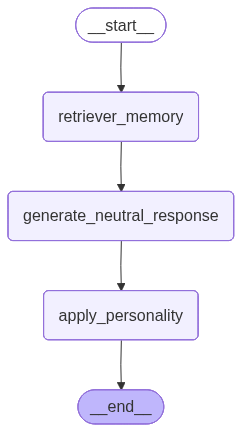

In [20]:
graph=StateGraph(PersonalityState)
graph.add_node("retriever_memory",retriever_memory)
graph.add_node("generate_neutral_response",generate_neutral_response)
graph.add_node("apply_personality",apply_personality)

graph.add_edge(START,"retriever_memory")
graph.add_edge("retriever_memory","generate_neutral_response")
graph.add_edge("generate_neutral_response","apply_personality")
graph.add_edge("apply_personality",END)

workflow=graph.compile()
workflow

In [21]:
from langchain_core.messages import HumanMessage

In [22]:
output=workflow.invoke({"messages":HumanMessage(content="I am so stressed about exams"),"tone":"calm_mentor"})
print(output)
output["base_response"]
output["final_response"]

{'messages': [HumanMessage(content='I am so stressed about exams', additional_kwargs={}, response_metadata={}, id='f1598b69-4459-4cb7-a145-b573cc426308')], 'memory': {'preferences': ['Italian food', 'pizza', 'wakes up at 6 AM', 'sci-fi movies', 'quiet places', 'classical music', 'night work', 'learning new programming languages'], 'emotional_pattrens': ['love', 'stressed', 'excited', 'enjoyment'], 'facts': ['I usually wake up at 6 AM every day.', 'I live in New York and work as a software engineer.', 'I am allergic to peanuts.']}, 'tone': 'calm_mentor', 'base_response': 'I’m sorry you’re feeling so stressed. Here are a few quick ideas that might help you manage the pressure and stay focused:\n\n1. **Plan your study time**  \n   * Make a simple schedule that breaks your revision into short, focused blocks (e.g., 25\u202fmin study + 5\u202fmin break).  \n   * Prioritise the topics you find most difficult or that carry the most marks.\n\n2. **Use active learning techniques**  \n   * Teach

'Hey there,\n\nI hear you’re feeling a bit overwhelmed right now, and that’s completely understandable. Let’s walk through some gentle, practical steps that can help you stay grounded and keep moving forward.\n\n1. **Plan your study time**  \n   Try mapping out a simple schedule—short, focused blocks of work followed by brief rests. For example, 25\u202fminutes of coding or reading, then a 5‑minute pause. Prioritise the topics that feel most challenging or carry the most weight; that way you’re tackling the toughest stuff when your mind is fresh.\n\n2. **Use active learning techniques**  \n   Teaching the material to an imaginary student, writing flashcards, or quizzing yourself with past questions can make the content stick. Spaced repetition—reviewing material at increasing intervals—works wonders compared to last‑minute cramming.\n\n3. **Take care of your body**  \n   You’re already a night‑time coder, but aim for 7–8 hours of sleep each night. A quick 20‑minute nap can be surprisin

In [23]:
output["final_response"]

'Hey there,\n\nI hear you’re feeling a bit overwhelmed right now, and that’s completely understandable. Let’s walk through some gentle, practical steps that can help you stay grounded and keep moving forward.\n\n1. **Plan your study time**  \n   Try mapping out a simple schedule—short, focused blocks of work followed by brief rests. For example, 25\u202fminutes of coding or reading, then a 5‑minute pause. Prioritise the topics that feel most challenging or carry the most weight; that way you’re tackling the toughest stuff when your mind is fresh.\n\n2. **Use active learning techniques**  \n   Teaching the material to an imaginary student, writing flashcards, or quizzing yourself with past questions can make the content stick. Spaced repetition—reviewing material at increasing intervals—works wonders compared to last‑minute cramming.\n\n3. **Take care of your body**  \n   You’re already a night‑time coder, but aim for 7–8 hours of sleep each night. A quick 20‑minute nap can be surprisin

In [24]:
output["base_response"]

'I’m sorry you’re feeling so stressed. Here are a few quick ideas that might help you manage the pressure and stay focused:\n\n1. **Plan your study time**  \n   * Make a simple schedule that breaks your revision into short, focused blocks (e.g., 25\u202fmin study + 5\u202fmin break).  \n   * Prioritise the topics you find most difficult or that carry the most marks.\n\n2. **Use active learning techniques**  \n   * Teach the material to an imaginary student, write out flashcards, or quiz yourself with past exam questions.  \n   * Spaced repetition (reviewing material at increasing intervals) is more effective than cramming.\n\n3. **Take care of your body**  \n   * Aim for 7–8\u202fhours of sleep each night; even a short 20‑minute nap can refresh you.  \n   * Eat balanced meals and stay hydrated; avoid excessive caffeine or sugary snacks.\n\n4. **Practice quick stress‑relief exercises**  \n   * Deep‑breathing: inhale for 4\u202fseconds, hold 4, exhale 4, repeat 5 times.  \n   * A 2‑minut